In [2]:
import random
import gym
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import rl_utils
from tqdm import tqdm
import env

In [3]:
class FeatureExtractor(torch.nn.Module):
    # input_dim = 72 + 8 * 128 = 1096
    # output_dim = 128 + 8 * 64 = 640
    def __init__(self, input_dim = 1096, batch_norm = True):
        "Three FC layers, two hidden layers, len of hidden_sizes: 2"
        super(FeatureExtractor, self).__init__()
        self.theta_dim = 72
        self.dvh_dim = 128
        hidden_sizes = [512, 256]
        self.theta_out_dim = 128
        self.fc_theta_1 = torch.nn.Linear(self.theta_dim, hidden_sizes[0])
        self.fc_theta_2 = torch.nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.fc_theta_3 = torch.nn.Linear(hidden_sizes[1], self.theta_out_dim)
        
        input_channels = (input_dim - self.theta_dim) // self.dvh_dim
        self.input_channels = input_channels
        dvh_output_size = input_channels * self.dvh_dim // 2
        Conv_dim = [input_channels * 4, input_channels * 8, input_channels * 16, input_channels * 32]
        self.fc1_dim =  input_channels * self.dvh_dim * 2
        self.batch_norm = batch_norm
        
        if self.batch_norm:
            self.bn1 = torch.nn.BatchNorm1d(Conv_dim[0])
            self.bn2 = torch.nn.BatchNorm1d(Conv_dim[1])
            self.bn3 = torch.nn.BatchNorm1d(Conv_dim[2])
            self.bn4 = torch.nn.BatchNorm1d(Conv_dim[3])
            self.bn5 = torch.nn.BatchNorm1d(dvh_output_size * 2)
            
        self.conv_1 = torch.nn.Conv1d(in_channels = input_channels, out_channels = Conv_dim[0],
                                      kernel_size = 3, stride = 1, padding = 1)
        self.conv_2 = torch.nn.Conv1d(in_channels = Conv_dim[0], out_channels = Conv_dim[1],
                                      kernel_size = 3, stride = 1, padding = 1)
        self.conv_3 = torch.nn.Conv1d(in_channels = Conv_dim[1], out_channels = Conv_dim[2],
                                      kernel_size = 3, stride = 1, padding = 1)
        self.conv_4 = torch.nn.Conv1d(in_channels = Conv_dim[2], out_channels = Conv_dim[3],
                                      kernel_size = 3, stride = 1, padding = 1)
        
        self.maxpool = torch.nn.MaxPool1d(3, stride=2, padding=1)
        self.relu = torch.nn.ReLU()
        
        self.fc_dvh_1 = torch.nn.Linear(self.fc1_dim, self.fc1_dim // 2)
        self.fc_dvh_2 = torch.nn.Linear(self.fc1_dim // 2, dvh_output_size)
        
    def forward(self, state):
        theta_state = state[:,:self.theta_dim]
        dvh_state = torch.reshape(state[:, self.theta_dim:], (-1, self.input_channels, self.dvh_dim))
        
        x = self.relu(self.fc_theta_1(theta_state))
        x = self.relu(self.fc_theta_2(x))
        x = self.fc_theta_3(x)
        
        if self.batch_norm:
            y = self.maxpool(self.relu(self.bn1(self.conv_1(dvh_state))))
            y = self.maxpool(self.relu(self.bn2(self.conv_2(y))))
            y = self.maxpool(self.relu(self.bn3(self.conv_3(y))))
            y = self.maxpool(self.relu(self.bn4(self.conv_4(y))))
            y = torch.reshape(y, (-1, self.fc1_dim))
            y = self.relu(self.bn5(self.fc_dvh_1(y)))
            y = self.fc_dvh_2(y)
        else:
            y = self.maxpool(self.relu(self.conv_1(dvh_state)))
            y = self.maxpool(self.relu(self.conv_2(y)))
            y = self.maxpool(self.relu(self.conv_3(y)))
            y = self.maxpool(self.relu(self.conv_4(y)))
            y = torch.reshape(y, (-1, self.fc1_dim))
            y = self.relu(self.bn5(self.fc_dvh_1(y)))
            y = self.relu(self.fc_dvh_1(y))
            y = self.fc_dvh_2(y)
        
        out = torch.cat((x, y), dim = 1)
        
        return out

In [4]:
# methon in Dong.
class Conv_Block(torch.nn.Module):
    def __init__(self, input_channels, output_channels):
        super(Conv_Block, self).__init__()
        self.conv_1 = torch.nn.Conv1d(in_channels = input_channels, out_channels = output_channels,
                                      kernel_size = 3, stride = 1, padding = 1)
        self.conv_2 = torch.nn.Conv1d(in_channels = output_channels, out_channels = output_channels,
                                      kernel_size = 3, stride = 1, padding = 1)
        self.maxpool = torch.nn.MaxPool1d(3, stride=2, padding=1)
        self.relu = torch.nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.conv_1(x))
        x = self.relu(self.conv_2(x))
        x = self.maxpool(x)
        return x

In [5]:
class Qnet(torch.nn.Module):
    def __init__(self, state_dim, action_dim = 72):
        super(Qnet, self).__init__()
        self.theta_dim = 72
        self.theta_out_dim = 128
        self.dvh_dim = 128
        self.dvh_channels = (state_dim - self.theta_dim) // self.dvh_dim
        self.feature = FeatureExtractor(input_dim = state_dim)
        self.feature_dim = self.theta_out_dim + self.dvh_channels * self.dvh_dim // 2
        # hidden layers: fit Q function, num : feature_num(72 + 128 * n) - 512 - 256 - 72
        hidden_dims = [512, 256]
        self.fc1 = torch.nn.Linear(self.feature_dim, hidden_dims[0])
        self.fc2 = torch.nn.Linear(hidden_dims[0], hidden_dims[1])
        self.fc3 = torch.nn.Linear(hidden_dims[1], action_dim)

    def forward(self, state):
        # Splitting and restructuring of state to theta and dvh
        # the feature extract of theta and dvh is done separately 
        # then merge two features into one
        x = self.feature(state)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [13]:
class DQN:
    def __init__(self,
                 state_dim,
                 action_dim,
                 learning_rate,
                 gamma,
                 epsilon,
                 target_update,
                 device,
                 dqn_type='VanillaDQN'):
        self.action_dim = action_dim
        self.q_net = Qnet(state_dim, self.action_dim).to(device)
        self.target_q_net = Qnet(state_dim, self.action_dim).to(device)
        self.optimizer = torch.optim.Adam(self.q_net.parameters(), lr=learning_rate)
        self.gamma = gamma
        self.epsilon = epsilon
        self.target_update = target_update
        self.count = 0
        self.dqn_type = dqn_type
        self.device = device

    def optional_action(self, state):
        # return a int list, which represents the optional action id
        # like [0, 1, 36, 71]
        theta_dim = 72
        theta = state[0,:theta_dim]
        optional_action_list = np.where(theta == 0)
        return optional_action_list[0]
    
    def take_action(self, state):
        optional_action_list = self.optional_action(state)
        if np.random.random() < self.epsilon:
            index = np.random.randint(len(optional_action_list))
            action = optional_action_list[index]
        else:
            state = torch.tensor(state, dtype=torch.float).to(self.device)
            action = self.q_net(state).argmax().item()
        return action
    
    def max_q_value(self, state):
        state = torch.tensor(state, dtype=torch.float).to(self.device)
        return self.q_net(state).max().item()

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'],
                              dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(
            self.device)
        rewards = torch.tensor(transition_dict['rewards'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],
                                   dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],
                             dtype=torch.float).view(-1, 1).to(self.device)

        # x.gather(1, index): 按列索引x的值（长度为len(index），第i个元素为x第i行，第index[i]列的值）
        # q_values即为该批次(batch_size)的value向量
        q_values = self.q_net(states).gather(1, actions)
        if self.dqn_type == 'DoubleDQN':
            max_action = self.q_net(next_states).max(1)[1].view(-1, 1)
            max_next_q_values = self.target_q_net(next_states).gather(1, max_action)
        else: # DQN
            max_next_q_values = self.target_q_net(next_states).max(1)[0].view(-1, 1)
        q_targets = rewards + self.gamma * max_next_q_values * (1 - dones)  # TD误差目标
        dqn_loss = torch.mean(F.mse_loss(q_values, q_targets))  #  MSE loss fucntion
        self.optimizer.zero_grad()  # PyTorch中默认梯度会累积,这里需要显式将梯度置为0
        dqn_loss.backward()  # 反向传播更新参数
        self.optimizer.step()

        if self.count % self.target_update == 0:
            self.target_q_net.load_state_dict(
                self.q_net.state_dict())  # 更新目标网络
        self.count += 1

In [11]:
lr = 1e-2
num_episodes = 200
gamma = 0.98
epsilon = 0.01
target_update = 50
buffer_size = 6
minimal_size = 2
batch_size = 2
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

In [8]:
data_path = r'D:\MyJupyter\RL_BAO\Data'
portpy_env = env.PortPyEnv(data_path = data_path, step_max_num = 3)

creating rinds.. This step may take some time due to dilation
Optimization structures created!!


In [14]:
def train_DQN(agent, env, num_episodes, replay_buffer, minimal_size,
              batch_size):
    return_list = []
    max_q_value_list = []
    max_q_value = 0
    for i in range(1):
        with tqdm(total=int(num_episodes / 10),
                  desc='Iteration %d' % i) as pbar:
            for i_episode in range(int(num_episodes / 10)):
                episode_return = 0
                state = env.reset()
                done = False
                while not done:
                    # batch_normalization 不允许输入的批量数为1
                    state = np.array([state, state])
                    action = agent.take_action(state)
                    max_q_value = agent.max_q_value(
                        state) * 0.005 + max_q_value * 0.995  # 平滑处理
                    max_q_value_list.append(max_q_value)  # 保存每个状态的最大Q值
                    next_state, reward, done, _ = env.step(action)
                    replay_buffer.add(state[0], action, reward, next_state, done)
                    state = next_state
                    episode_return += reward
                    if replay_buffer.size() > minimal_size:
                        b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(batch_size)
                        transition_dict = {
                            'states': b_s,
                            'actions': b_a,
                            'next_states': b_ns,
                            'rewards': b_r,
                            'dones': b_d
                        }
                        agent.update(transition_dict)
                return_list.append(episode_return)
                if (i_episode + 1) % 10 == 0:
                    pbar.set_postfix({
                        'episode':
                        '%d' % (num_episodes / 10 * i + i_episode + 1),
                        'return':
                        '%.3f' % np.mean(return_list[-10:])
                    })
                pbar.update(1)
    return return_list, max_q_value_list

In [15]:
random.seed(0)
np.random.seed(0)
portpy_env.seed(0)
torch.manual_seed(0)
# state_dim = 72 + 8 * 128 = 1096
state_dim = 1096
action_dim = 72
replay_buffer = rl_utils.ReplayBuffer(buffer_size)
agent = DQN(state_dim, action_dim, lr, gamma, epsilon,
            target_update, device)
return_list, max_q_value_list = train_DQN(agent, portpy_env, num_episodes,
                                          replay_buffer, minimal_size,
                                          batch_size)

Iteration 0:   0%|                                                                              | 0/20 [00:00<?, ?it/s]

Creating BEV..
Loading sparse influence matrix...
Done
Objective Start
Objective done
Constraints Start
Constraints done
Running Optimization..
Optimal value: 66085.25501755641
Elapsed time: 12.915423393249512 seconds
Creating BEV..
Loading sparse influence matrix...
Done
Objective Start
Objective done
Constraints Start
Constraints done
Running Optimization..
Optimal value: 66085.2660412982
Elapsed time: 15.670580387115479 seconds
Creating BEV..
Loading sparse influence matrix...
Done
Objective Start
Objective done
Constraints Start
Constraints done
Running Optimization..
Optimal value: 66085.26535015475
Elapsed time: 13.186717510223389 seconds
Creating BEV..
Loading sparse influence matrix...
Done
Objective Start
Objective done
Constraints Start
Constraints done
Running Optimization..
Optimal value: 3595.029462701458
Elapsed time: 23.526299715042114 seconds


Iteration 0:   5%|███▌                                                                  | 1/20 [01:15<23:55, 75.54s/it]

Creating BEV..
Loading sparse influence matrix...
Done
Objective Start
Objective done
Constraints Start
Constraints done
Running Optimization..
Optimal value: 100358.30120635209
Elapsed time: 18.960392713546753 seconds


Iteration 0:  10%|███████                                                               | 2/20 [01:35<12:51, 42.88s/it]

Creating BEV..
Loading sparse influence matrix...
Done
Objective Start
Objective done
Constraints Start
Constraints done
Running Optimization..
Optimal value: 100358.31860740624
Elapsed time: 20.763087511062622 seconds


Iteration 0:  15%|██████████▌                                                           | 3/20 [01:57<09:24, 33.19s/it]

Creating BEV..
Loading sparse influence matrix...
Done
Objective Start
Objective done
Constraints Start
Constraints done
Running Optimization..
Optimal value: 100358.32112367342
Elapsed time: 23.48955535888672 seconds


Iteration 0:  20%|██████████████                                                        | 4/20 [02:21<07:54, 29.69s/it]

Creating BEV..
Loading sparse influence matrix...
Done
Objective Start
Objective done
Constraints Start
Constraints done
Running Optimization..
Optimal value: 100358.30411548409
Elapsed time: 27.209455728530884 seconds


Iteration 0:  25%|█████████████████▌                                                    | 5/20 [02:49<07:16, 29.09s/it]

Creating BEV..
Loading sparse influence matrix...
Done
Objective Start
Objective done
Constraints Start
Constraints done
Running Optimization..
Optimal value: 100358.29000367378
Elapsed time: 25.046062707901 seconds


Iteration 0:  30%|█████████████████████                                                 | 6/20 [03:15<06:31, 27.99s/it]

Creating BEV..
Loading sparse influence matrix...
Done
Objective Start
Objective done
Constraints Start
Constraints done
Running Optimization..
Optimal value: 66085.26728477314
Elapsed time: 28.759214639663696 seconds


Iteration 0:  35%|████████████████████████▌                                             | 7/20 [03:44<06:10, 28.50s/it]

Creating BEV..
Loading sparse influence matrix...
Done
Objective Start
Objective done
Constraints Start
Constraints done
Running Optimization..
Optimal value: 66085.26208743571
Elapsed time: 27.022502660751343 seconds


Iteration 0:  40%|████████████████████████████                                          | 8/20 [04:13<05:40, 28.37s/it]

Creating BEV..
Loading sparse influence matrix...
Done
Objective Start
Objective done
Constraints Start
Constraints done
Running Optimization..
Optimal value: 66085.2553736168
Elapsed time: 28.114092588424683 seconds


Iteration 0:  45%|███████████████████████████████▌                                      | 9/20 [04:42<05:14, 28.59s/it]

Creating BEV..
Loading sparse influence matrix...
Done
Objective Start
Objective done
Constraints Start
Constraints done
Running Optimization..
Optimal value: 66085.25901539277
Elapsed time: 30.862940073013306 seconds


Iteration 0:  50%|█████████████████████                     | 10/20 [05:13<04:55, 29.55s/it, episode=10, return=64.800]

Creating BEV..
Loading sparse influence matrix...
Done
Objective Start
Objective done
Constraints Start
Constraints done
Running Optimization..
Optimal value: 66085.26207904387
Elapsed time: 33.46454191207886 seconds


Iteration 0:  55%|███████████████████████                   | 11/20 [05:48<04:39, 31.01s/it, episode=10, return=64.800]

Creating BEV..
Loading sparse influence matrix...
Done
Objective Start
Objective done
Constraints Start
Constraints done
Running Optimization..
Optimal value: 66085.26666318532
Elapsed time: 34.72940921783447 seconds


Iteration 0:  60%|█████████████████████████▏                | 12/20 [06:23<04:19, 32.41s/it, episode=10, return=64.800]

Creating BEV..
Loading sparse influence matrix...
Done
Objective Start
Objective done
Constraints Start
Constraints done
Running Optimization..
Optimal value: 66085.26828784104
Elapsed time: 38.53583526611328 seconds


Iteration 0:  65%|███████████████████████████▎              | 13/20 [07:03<04:01, 34.52s/it, episode=10, return=64.800]

Creating BEV..
Loading sparse influence matrix...
Done
Objective Start
Objective done
Constraints Start
Constraints done
Running Optimization..
Optimal value: 66085.26578627377
Elapsed time: 40.86039137840271 seconds


Iteration 0:  70%|█████████████████████████████▍            | 14/20 [07:44<03:40, 36.71s/it, episode=10, return=64.800]

Creating BEV..
Loading sparse influence matrix...
Done
Objective Start
Objective done
Constraints Start
Constraints done
Running Optimization..
Optimal value: 66085.25377648891
Elapsed time: 43.567569971084595 seconds


Iteration 0:  75%|███████████████████████████████▌          | 15/20 [08:29<03:15, 39.05s/it, episode=10, return=64.800]

Creating BEV..
Loading sparse influence matrix...
Done
Objective Start
Objective done
Constraints Start
Constraints done
Running Optimization..
Optimal value: 66085.25593127216
Elapsed time: 44.27509045600891 seconds


Iteration 0:  80%|█████████████████████████████████▌        | 16/20 [09:14<02:43, 40.91s/it, episode=10, return=64.800]

Creating BEV..
Loading sparse influence matrix...
Done
Objective Start
Objective done
Constraints Start
Constraints done
Running Optimization..
Optimal value: 66085.259990453
Elapsed time: 45.66170334815979 seconds


Iteration 0:  85%|███████████████████████████████████▋      | 17/20 [10:01<02:07, 42.61s/it, episode=10, return=64.800]

Creating BEV..
Loading sparse influence matrix...
Done
Objective Start
Objective done
Constraints Start
Constraints done
Running Optimization..
Optimal value: 66085.2629195493
Elapsed time: 48.751964807510376 seconds


Iteration 0:  90%|█████████████████████████████████████▊    | 18/20 [10:50<01:29, 44.76s/it, episode=10, return=64.800]

Creating BEV..
Loading sparse influence matrix...
Done
Objective Start
Objective done
Constraints Start
Constraints done
Running Optimization..
Optimal value: 66085.259826963
Elapsed time: 52.09355354309082 seconds


Iteration 0:  95%|███████████████████████████████████████▉  | 19/20 [11:44<00:47, 47.25s/it, episode=10, return=64.800]

Creating BEV..
Loading sparse influence matrix...
Done
Objective Start
Objective done
Constraints Start
Constraints done
Running Optimization..
Optimal value: 66085.2684308791
Elapsed time: 55.44804501533508 seconds


Iteration 0: 100%|██████████████████████████████████████████| 20/20 [12:40<00:00, 38.02s/it, episode=20, return=66.000]


In [16]:
print(return_list, max_q_value_list)

[119, 53, 53, 53, 53, 53, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66] [0.0004086413234472275, 0.0008098867941647768, 0.0012091260375287384, 0.0026914045130806883, 0.003968596517147594, 0.038938260732895594, 0.22431594568045182, 0.2661122565007556, 0.2712830563499199, 0.27140441783399366, 0.27330499551584647, 0.27929092341245093, 0.29336746264609664, 0.3209611822214465, 0.3714052740535643, 0.4622562154414752, 0.6224996371230569, 0.8979650579437892, 1.346610799365496, 1.8613607089306803, 2.316272960561808, 2.6729189440866357, 2.942394830170646]


NameError: name 'env_name' is not defined

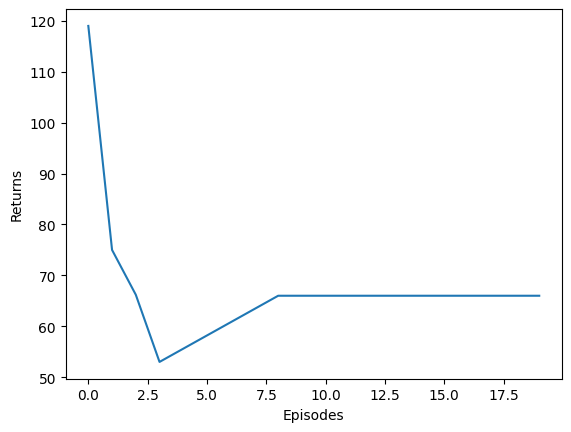

In [17]:
episodes_list = list(range(len(return_list)))
mv_return = rl_utils.moving_average(return_list, 5)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DQN on {}'.format(env_name))
plt.show()

frames_list = list(range(len(max_q_value_list)))
plt.plot(frames_list, max_q_value_list)
plt.axhline(0, c='orange', ls='--')
plt.axhline(10, c='red', ls='--')
plt.xlabel('Frames')
plt.ylabel('Q value')
plt.title('DQN on {}'.format(env_name))
plt.show()


In [ ]:
random.seed(0)
np.random.seed(0)
env.seed(0)
torch.manual_seed(0)
replay_buffer = rl_utils.ReplayBuffer(buffer_size)
agent = DQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon,
            target_update, device, 'DoubleDQN')
return_list, max_q_value_list = train_DQN(agent, env, num_episodes,
                                          replay_buffer, minimal_size,
                                          batch_size)

episodes_list = list(range(len(return_list)))
mv_return = rl_utils.moving_average(return_list, 5)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Double DQN on {}'.format(env_name))
plt.show()

frames_list = list(range(len(max_q_value_list)))
plt.plot(frames_list, max_q_value_list)
plt.axhline(0, c='orange', ls='--')
plt.axhline(10, c='red', ls='--')
plt.xlabel('Frames')
plt.ylabel('Q value')
plt.title('Double DQN on {}'.format(env_name))
plt.show()